In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis
from model import scMSModel
from model import *

import ipywidgets as widgets
from ipywidgets import Box, IntSlider
%matplotlib widget
import numpy as np

In [3]:
data = pd.read_pickle('developing_brain/exprMatrix.pkl')
data_cortex = pd.read_pickle('developing_brain/exprMatrix_cortex.pkl')
metadata = pd.read_pickle('developing_brain/meta.pkl')
metadata_cortex = pd.read_pickle('developing_brain/meta_cortex.pkl')

<AxesSubplot:xlabel='Structure', ylabel='count'>

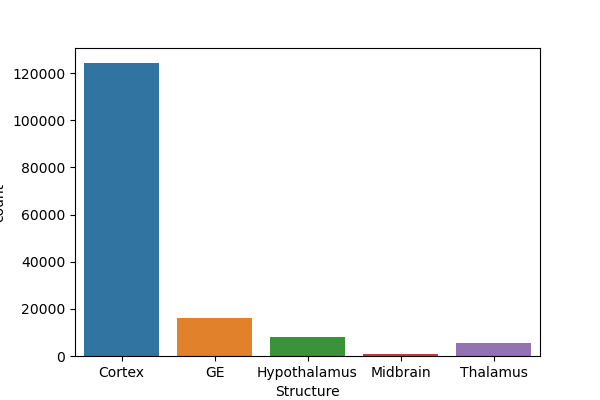

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'Structure', data=metadata)

<AxesSubplot:xlabel='Area.fixed', ylabel='count'>

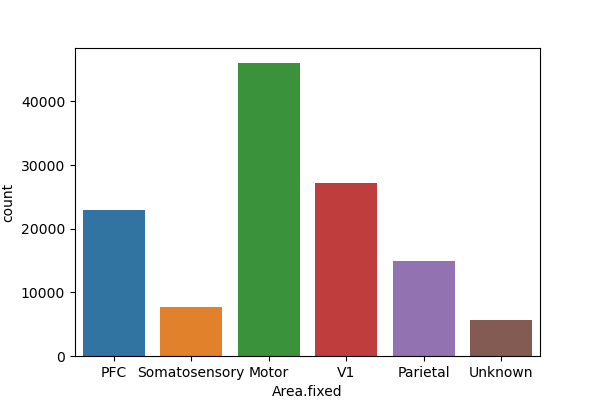

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'Area.fixed', data=metadata_cortex)

<AxesSubplot:xlabel='Individual', ylabel='count'>

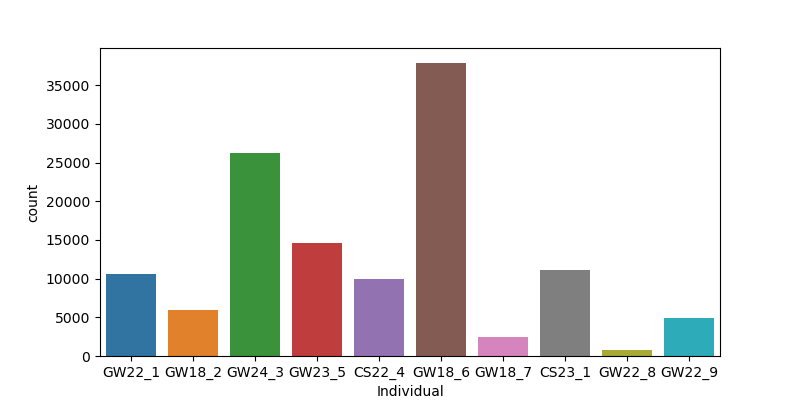

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'Individual', data=metadata_cortex)

In [4]:
sc_db = scMSAnalysis(metadata_cortex)
sc_db.preprocessing(data_cortex,norm_method='None',feat_drop_rate=0.005,cell_drop_rate=0.005)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered intensity matrix with shape (124464, 600)


In [5]:
sc_db.get_labels(['Age.fixed','Area.fixed','Individual'])

In [29]:
sc_db.analyze(n_neighbors=15, n_pcs=15, min_dist=0.6, resolution = 0.15,
              categories=['Area.fixed','Age.fixed'])

computing neighbors..
performing umap...
performing clustering...


The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Age.fixed' as categorical
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Area.fixed' as categorical
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Individual' as categorical
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'mz' as categorical
invalid value encountered in log2


In [30]:
show_embed = widgets.interactive(sc_db.show_cellEmbed, label=sc_db.adata.obs.columns,
                                 embed_method=sc_db.adata.obsm.keys(),size=(0.01,0.1,0.05));

In [31]:
show_embed

interactive(children=(Dropdown(description='label', options=('Age.fixed', 'Area.fixed', 'Individual', 'leiden'…

In [33]:
plt.savefig('figures/umap_unsupervised_develop_age.pdf',dpi=300)

In [56]:
show_embed_label = widgets.interactive(sc_db.show_cellEmbed_label,label=show_embed.kwargs['label'],
                                 classes=sc_db.label_class[show_embed.kwargs['label']],embed_method=sc_db.adata.obsm.keys(),size=(0.01,0.1,0.05));


In [57]:
show_embed_label

interactive(children=(Text(value='Area.fixed', description='label'), Dropdown(description='classes', options=(…

In [26]:
label = 'Age.fixed'
show_feat = widgets.interactive(sc_db.show_featrank, label = label, region = sc_db.label_class[label], 
                                rank_by=sc_db.feat_rank[label].keys(), num_select=500,
                                num_show=IntSlider(min=0, max=500, step=20, value=0));

In [27]:
show_feat

interactive(children=(Text(value='Area.fixed', description='label'), Dropdown(description='region', options=('…

In [83]:
data

NameError: name 'data' is not defined

In [6]:
scmodel = scMSModel(sc_db.intens_mtx,metadata=sc_db.metadata)

In [7]:
scmodel.get_labels(['Area.fixed','Age.fixed'])

In [34]:
scmodel.train_models(k=5, cv=False, shap=False, model_names=['GBT'], label_name='Age.fixed')

performing 1 fold cross validation for GBT
cross validation 0...
[17:01:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion matrix, without normalization
[[ 5279     0     0     1     0]
 [    0 11635     0     0     0]
 [    0     0  4066     0     0]
 [    0     0     0  3667     0]
 [    0     0     0     0  6468]]


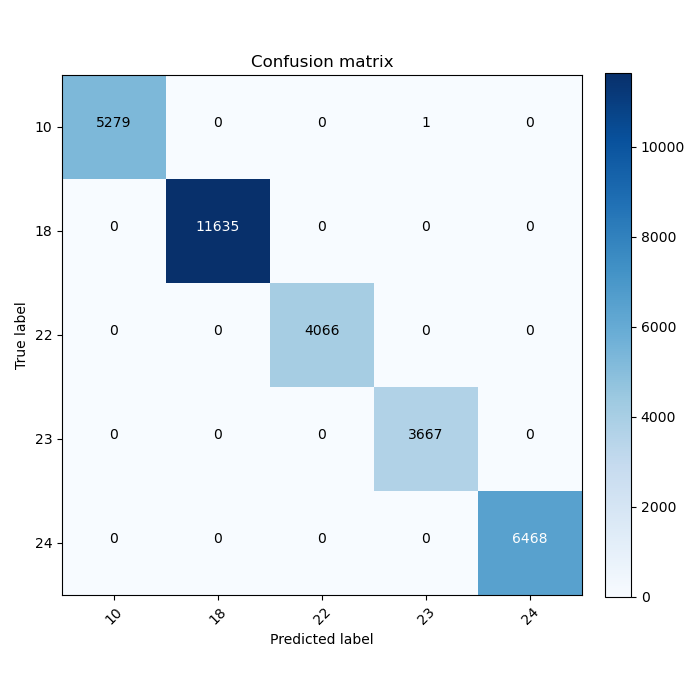

In [36]:
y_pred = scmodel.model['GBT'].predict(scmodel.intens_mtx.loc[scmodel.cv_test[0],scmodel.feature_names].values)
y_test = scmodel.metadata.loc[scmodel.cv_test[0]]['Age.fixed_int'].values
cf_matrix = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(cf_matrix, classes=scmodel.label_class['Age.fixed'])
plt.savefig('figures/cm_develop_age.pdf')

In [37]:
from shap import TreeExplainer

e = TreeExplainer(scmodel.model['GBT'])
shap_values = e.shap_values(scmodel.intens_mtx.loc[:,scmodel.feature_names].values)

In [38]:
shap_df = pd.DataFrame(np.concatenate(shap_values,1))

sc_db_shap = scMSAnalysis(scmodel.metadata.reset_index())
sc_db_shap.preprocessing(shap_df,norm_method='None',feat_drop_rate=0,cell_drop_rate=0)

filtered intensity matrix with shape (124464, 3010)


Transforming to str index.


In [39]:
sc_db_shap.get_labels(['Age.fixed'])

In [3]:
sc_db_shap.analyze(n_neighbors=30, n_pcs=50, min_dist=0.5, resolution = 0.2,
              categories='Age.fixed')

In [41]:
show_embed = widgets.interactive(sc_db_shap.show_cellEmbed, label=sc_db_shap.adata.obs.columns,
                                 embed_method=sc_db_shap.adata.obsm.keys(),size=(0.01,0.1,0.05));

In [42]:
show_embed

interactive(children=(Dropdown(description='label', options=('Age.fixed', 'leiden'), value='Age.fixed'), Dropd…

In [44]:
plt.savefig('figures/umap_supervised_develop_age.pdf',dpi=300)

In [27]:
f1 = []
model_names = []
for key in scmodel.test_metrics.keys():
    f1+=[metric['f1'] for metric in scmodel.test_metrics[key]]
    model_names+=[key for metric in scmodel.test_metrics[key]]
cv_df = pd.DataFrame({'f1':f1,'model':model_names})

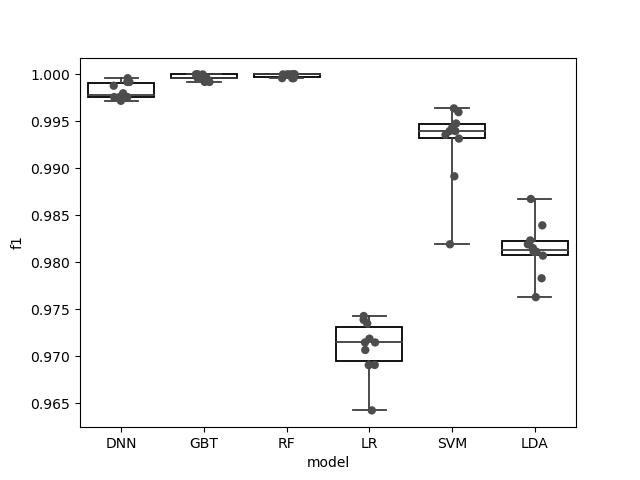

In [29]:
plt.figure()
ax = sns.boxplot(x='model',y='f1',data=cv_df,fliersize=0, whis = 100, linewidth=1.3)
sns.stripplot(x='model',y='f1',data=cv_df,
              size=6, color=".3", linewidth=0)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.show()
#plt.savefig('figures/developing_brain_f1_10fold.pdf')

In [48]:
predicted,y_pred_tags = scmodel.predict_DNN(scmodel.intens_mtx.loc[scmodel.cv_test[0]].values.astype(float))

In [80]:
from sklearn.preprocessing import OneHotEncoder
encode = OneHotEncoder().fit_transform(scmodel.metadata['Area.fixed_int'].loc[scmodel.cv_test[0]].values.reshape(-1, 1))

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, f1_score
nclass=6
TPR = []
FPR = []
for i in range(nclass):
    tpr,fpr,_=roc_curve(encode.toarray()[:,i],predicted[:,i])
    TPR.append(tpr);FPR.append(fpr)

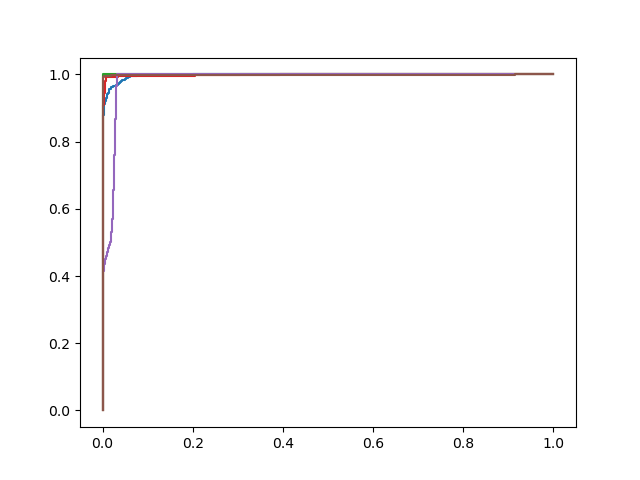

In [82]:
plt.figure()
for i in range(nclass):
    plt.plot(TPR[i],FPR[i])
plt.show()